# Neural Networks

This is my attempt to implement backpropagation algorithm for neural networks. I was first exposed to this exercise in [Andrew Ng's Intro to Machine Learning class on Coursera](https://www.coursera.org/learn/machine-learning) where it was used to recognize hand written digits. I revisited it to implement it using Python3 and Numpy to extend my understanding of the concepts.

In [1]:
# setup environment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as opt

In [2]:
# Load Training Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X = mnist["data"]
y = mnist["target"]
print(f"y[0] type: {type(y[0])}") # targets as strings
y = y.astype(np.int8) # targets as integers
y[y==0] = 10 # map targets 0 --> 10
X /= 255 # scale 0-255 --> 0-1

print("\n--shapes--")
print(f"X: {X.shape}") # 70000 images, each 28 x 28 pixels
print(f"y: {y.shape}")


# trim and split into training and test sets
np.random.seed(42)
indx = np.random.permutation(len(X)) # random indexes
indx_train = indx[:50000]
indx_valid = indx[50000:60000]
indx_test = indx[60000:70000]

X_train = X[indx_train]
y_train = y[indx_train]
X_valid = X[indx_valid]
y_valid = y[indx_valid]
X_test = X[indx_test]
y_test = y[indx_test]

print(f"X_train: {X_train.shape}")
m, n = X_train.shape # m samples, n features
img_size=(28, 28) # 28 x 28 pixels

y[0] type: <class 'str'>

--shapes--
X: (70000, 784)
y: (70000,)
X_train: (50000, 784)


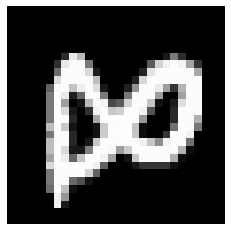

In [4]:
# function to plot an image
def plot_image(image):
    '''displays image, image pixels is assumed to be flattened'''
    image = image.reshape(img_size, order="F") # back to 28x28 pixels
    plt.imshow(image, cmap="gray", interpolation="None")
    plt.axis("off")

# plot random digit
plot_image(X_train[0])

In [5]:
# function to plot images
def plot_images(images, ncols=8, img_size=img_size):
    '''plot images in a grid of ncols'''
    ncols = min(len(images), ncols) # adjust for sample size < ncols
    images = [image.reshape(img_size) for image in images]
    nrows = (len(images) - 1) // ncols + 1
    row_images = []
    nempty_cells = nrows * ncols - len(images) # empty cells on last row
    for ecell in range(nempty_cells):
        images.append(np.zeros(img_size)) # append blank images
    for row in range(nrows):
        rimages = images[row * ncols : (row + 1) * ncols]
        row_images.append(np.concatenate(rimages, axis=1)) # stich to row
    image = np.concatenate(row_images, axis=0) # stack rows
    plt.imshow(image, cmap="gray", interpolation="None")   
    plt.axis("off")

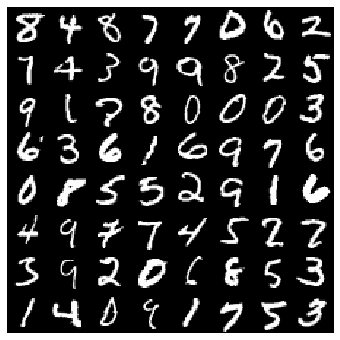

In [6]:
# plot random digits
random_images = X_train[0:64] # random images
plt.figure(figsize=(6,6))
plot_images(random_images, ncols=8)

### Neural network model 
![Feedforward propagation](nn_ff.png)

Screen shots from Andrew Ng's lecture on Coursera. Feedforward propagation for cost function (above) and back propagation for the cost function's gradient (below).

![Feedforward propagation](nn_bckprp.png)

# Cost function via feedforward- and back-propagation)

In [7]:
# utility functions
def sigmoid(z):
    '''
    Computes sigmoid function for any variable z and returns it.
    Return type ndarray.
    '''
    return 1 / (1 + np.exp(-z)) # same shape as z

def sigmoid_gradient(z):
    '''
    Computes gradient of the sigmoid function evaluated at z
    and returns it. Return type ndarray.
    '''
    return sigmoid(z) * (1 - sigmoid(z))

# randomly initialize weights
def initialize_weights(l_in, l_out):
    '''
    Randomly initialization of weights for a layer with
    l_in incoming connections and l_out outgoing connections.

    -- parameters --
    l_in: number of incoming connections, integer
    l_out: number of outgoing connections, integer
    
    -- returns --
    W: randomly initialized weights, ndarray shape (l_out, l_in + 1)
       includes bias    
    '''
    epsilon_init = 0.12 # sqrt(6)/sqrt(l_in + l_out)
    W = np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init

    return W

In [8]:
# cost function for neural network
def cost_function(flat_weights, il_size, hl_size, nlabels, X, y, l):
    '''Computes neural network cost function for a three layer
    neural network -- input layer, hidden layer, and output layer.
    
    -- parameters --
    flat_weights: flattned neural network weights, ndarray of shape (-1,).
        -1 value depends on the size of the input, hidden, and output layers.
        eg. for input, hidden, and output layers with 784, 25, and 10 units,
            respectively, the flat_weights would be of size
            ((784+1)*25 + (25+1)*10, ) = (5102500, ).
            The +1 factor comes from the bias (see model above for clarity)
            
    il_size: input layer size, integer
    hl_size: hidden layer size, integer
    nlabels: number of target labels, integer
    X: matrix of m samples x n features, ndarray of shape (m,n)
    y: targets or labels, ndarray of shape (m,)
    l: regularization parameter, float
    
    -- returns --
    j: neural network cost, float
    grad: neural network gradient, ndarray of shape (-1, ); has the same
          shape as flat_weights, see its description above. 
    '''
    
    # reshape flat_weights to get thetas (see model above for clarity)
    
    # sliced flat_weights reshaped to shape (hl_size, il_size + 1)
    theta1 = np.reshape(flat_weights[0: ((il_size + 1) * hl_size), ],
                        (hl_size, il_size + 1)) # + 1 from bias
    
    # sliced flat_weights reshaped to shape (nlabels, hl_size + 1)
    theta2 = np.reshape(flat_weights[((il_size + 1) * hl_size):, ],
                        (nlabels, hl_size + 1))
    
    m, n = X.shape # m samples, n features

    # FEEDFORWARD PROPAGATION (to get cost) -----------------------------
    a1 = np.c_[np.ones((m, 1)), X] # add bias, shape (m, n+1)
    
    z2 = a1 @ theta1.T # (m, n+1) x (n+1, h) --> (m, h)
    # Note: n now includes bias; h indicats hl_size for brevity
    
    a2 = sigmoid(z2) # shape (m, h)
    a2 = np.c_[np.ones((m, 1)), a2] # add bias, shape (m, h+1)
    
    z3 = a2 @ theta2.T # (m, h+1) x (h+1, lb) --> (m, lb); lb for nlabels
    a3 = sigmoid(z3) # shape (m, lb)
    
    # ylabels into matrix of nlabel vectors
    Y = np.zeros(shape=(m, nlabels)) # shape (m, lb)
    Y[np.arange(m), y-1] = 1 # shape (m, lb)
    
    # cost (j), scalar
    j_u = (1.0/m) * np.sum( (-Y * np.log(a3)) - (1 - Y) * np.log(1 - a3))
    
    theta1_sq = np.square(theta1[:, 1:]) # skip bias
    theta2_sq = np.square(theta2[:, 1:]) # skip bias
    j_r = 1.0 * l/(2*m) * ( np.sum(theta1_sq) + np.sum(theta2_sq) )
    
    j = j_u + j_r # regularized cost from forward propagation
    
    # BACKWARD PROPAGATION ----------------------------------------------
    
    d3 = a3 - Y # shape (m, lb)
    d2 = (d3 @ theta2[:, 1:]) * sigmoid_gradient(z2) # shape (m, h)
    # (m, lb) x (lb, h+1)[:, 1:] --> (m, lb) x (lb, h) --> (m, h)
    #     whithout slicing the resulting shape would have been (m, h+1)
    
    D1 = d2.T @ a1 # (h, m) x (m, n+1) --> (h, n+1)
    D2 = d3.T @ a2 # (lb, m) x (m, h+1) --> (lb, h+1)
    
    # unregularized gradients
    theta1_grad = (1.0/m) * D1 # shape (h, n+1)
    theta2_grad = (1.0/m) * D2 # shape (lb, h+1)
    
    # regularized gradients
    # to nullify their contributions, set bias column values to 0
    theta1[:, 1] = 0
    theta2[:, 1] = 0
    
    theta1_grad += ((l/m) * theta1) # shape (h, n+1)
    theta2_grad += ((l/m) * theta2) # shape (lb, h+1)
    
    grad = np.r_[theta1_grad.ravel(), theta2_grad.ravel()] # shape (-1, )
    
    return j, grad


In [9]:
# initial parameters
l = 1.0 # regularization parameter
il_size = 784  # 28x28 pixels
hl_size = 49   # hidden units

nlabels = 10   # 10 labels, from 1 to 10; 0 --> 10

itheta1 = initialize_weights(il_size, hl_size) # initial theta1
itheta2 = initialize_weights(hl_size, nlabels) # initial theta2
iweights = np.r_[itheta1.ravel(), itheta2.ravel()]

## Train neural network
Using the cost function and the initialized weights, scipy's optimization module can be used
to train the neural network.

In [10]:
%%time
nn_clf = opt.minimize(fun=cost_function, x0=iweights,
                    args=(il_size, hl_size, nlabels, X_train, y_train, l),
                      method='TNC', jac=True, options={'maxiter': 300})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multiply


CPU times: user 7min 4s, sys: 1min 24s, total: 8min 29s
Wall time: 4min 50s


In [11]:
fit_weights = nn_clf.x

fit_theta1 = np.reshape(fit_weights[0:(il_size + 1) * hl_size, ],
                             (hl_size, il_size + 1) )
fit_theta2 = np.reshape(fit_weights[(il_size + 1) * hl_size:, ],
                             (nlabels, hl_size + 1) )

## Visualize the hidden layers

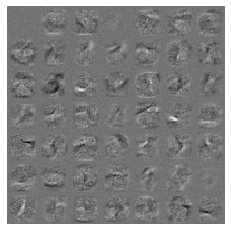

In [12]:
plot_images(fit_theta1[:, 1:], ncols=7) # first layer

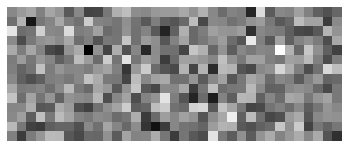

In [13]:
plot_images(fit_theta2[:, 1:], ncols=5, img_size=(7,7)) # second layer
# Image is grainy, only has 49 pixels (vs. 784 for one above)

## Model estimated labels

In [14]:
def predict(theta1, theta2, X):
    '''
    Predicts the label for an input given the fit weights.

    -- parameters --
    theta1: fit weights of layer 1; ndarray shape (hl_size, il_size + 1)
    theta2: fit weights of layer 2; ndarray shape (nlabels, hl_size + 1)
    X: m samples with n features, ndarray shape (m, n)
        
    -- returns --
    p: the prediction for x; ndarray, shape (m,)       
    '''
    m, n = X.shape
    X = np.c_[np.ones((m, 1)), X] # add bias column
    a2 = sigmoid(X @ theta1.T) # (m, n+1) x (n+1, h) --> (m, h)
    a2 = np.c_[np.ones((m, 1)), a2] # add bias, shape (m, h+1)
    a3 = sigmoid(a2 @ theta2.T) # (m, h+1) x (h+1, lb) --> (m, lb)

    p = np.argmax(a3, axis=1) # index with highest probability
    p += 1  # to match matlab index starting at 1 (vs. 0 in python)

    return p

In [15]:
nn_pred = predict(fit_theta1, fit_theta2, X_train)
print(f"NN accuracy: {np.mean(nn_pred == y_train):.4f}")

NN accuracy: 0.9829


## Plot predictions

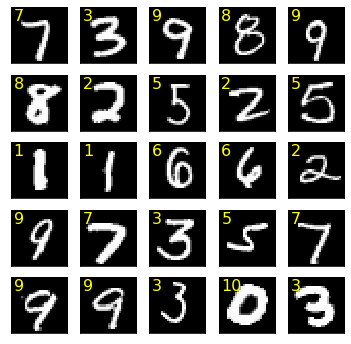

In [16]:
# plot 5x5 digits
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(6,6)) 
axs = axs.flatten()  # handles to subplot axes objects

indxs = np.random.choice(m, 25, replace=False) # 25 random indexes from m

for i, indx in enumerate(indxs):
    image = np.reshape(X_train[indx], img_size) # image
    label = str(nn_pred[indx]) # predicted label for that image
    
    # plot image and its label
    axs[i].imshow(image, cmap="gray", interpolation="None")
    axs[i].annotate(label, xy=(0.05, 0.75), xycoords="axes fraction",
                    color="yellow", fontsize=16)
    axs[i].xaxis.set_visible(False)  # hide axes labels
    axs[i].yaxis.set_visible(False)

## Check metrics on the test set

In [17]:
nn_pred_test = predict(fit_theta1, fit_theta2, X_test)
print(f"NN accuracy: {np.mean(nn_pred_test == y_test):.4f}")

NN accuracy: 0.9638


#### The neural network model written above provided test set accuracy > 96%.

## Compare against NN model from keras library

In [18]:
from tensorflow import keras
keras.backend.clear_session()

In [19]:
%%time
model = keras.models.Sequential([
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(49, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

y_train[y_train==10] = 0 # map back target labels 10 --> 0
y_valid[y_valid==10] = 0 # map back labels 10 --> 0
y_test[y_test==10] = 0 # map back labels 10 --> 0

model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0)

CPU times: user 1min 55s, sys: 10.3 s, total: 2min 5s
Wall time: 1min 6s


In [20]:
test_accuracy = model.evaluate(X_test, y_test)[1]
print(f"Keras accuracy (test): {test_accuracy:.4f}")

10000/10000 [==============================] - 0s 37us/sample - loss: 0.0828 - accuracy: 0.9830
Keras accuracy (test): 0.9830
